<h1 align="center">研究生《深度学习》课程<br>实验报告</h1>
<div style="text-align: center;">
    <div><span style="display: inline-block; width: 65px; text-align: center;">课程名称</span><span style="display: inline-block; width: 25px;">:</span><span style="display: inline-block; width: 210px; font-weight: bold; text-align: left;">深度学习 M502019B</span></div>
    <div><span style="display: inline-block; width: 65px; text-align: center;">实验题目</span><span style="display: inline-block; width: 25px;">:</span><span style="display: inline-block; width: 210px; font-weight: bold; text-align: left;">Pytorch基本操作实验</span></div>
    <div><span style="display: inline-block; width: 65px; text-align: center;">学号</span><span style="display: inline-block; width: 25px;">:</span><span style="display: inline-block; width: 210px; font-weight: bold; text-align: left;">25120323</span></div>
    <div><span style="display: inline-block; width: 65px; text-align: center;">姓名</span><span style="display: inline-block; width: 25px;">:</span><span style="display: inline-block; width: 210px; font-weight: bold; text-align: left;">柯劲帆</span></div>
    <div><span style="display: inline-block; width: 65px; text-align: center;">授课老师</span><span style="display: inline-block; width: 25px;">:</span><span style="display: inline-block; width: 210px; font-weight: bold; text-align: left;">原继东</span></div>
    <div><span style="display: inline-block; width: 65px; text-align: center;">报告日期</span><span style="display: inline-block; width: 25px;">:</span><span style="display: inline-block; width: 210px; font-weight: bold; text-align: left;">2025年8月4日</span></div>
</div>

In [1]:
import numpy as np
import torch
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader, Subset, random_split
from torch import nn
from torchvision import datasets, transforms
from multiprocessing import cpu_count
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import pandas as pd
from typing import Literal, Union, Optional

print('Pytorch version:',torch.__version__)
if not torch.cuda.is_available():
    print('CUDA is_available:', torch.cuda.is_available())
else:
    print('CUDA version:', torch.version.cuda)
    print('CUDA device count:', torch.cuda.device_count())
    print('CUDA device name:', torch.cuda.get_device_name())
    print('CUDA device capability:', torch.cuda.get_device_capability())
    print('CUDA device memory:', f'{torch.cuda.get_device_properties(0).total_memory/1024/1024/1024:.2f}', 'GB')
print('CPU count:', cpu_count())

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

Pytorch version: 2.7.1+cu118
CUDA version: 11.8
CUDA device count: 1
CUDA device name: NVIDIA TITAN Xp
CUDA device capability: (6, 1)
CUDA device memory: 11.90 GB
CPU count: 4


# 任务一
**手动实现前馈神经网络解决上述回归、二分类、多分类任务。**
- 从训练时间、预测精度、Loss变化等角度分析实验结果（最好使用图表展示）

In [2]:
torch.cuda.empty_cache()

首先生成数据集。

一共有3个数据集：

1. 回归任务数据集。
   - 生成单个数据集。
   - 数据集的大小为$10000$且训练集大小为$7000$，测试集大小为$3000$。
   - 数据集的样本特征维度$p$为$500$，且服从如下的高维线性函数：$y = 0.028 + \sum_{i=1}^{p}0.0056 x_i + \epsilon $。
2. 二分类任务数据集。
   - 共生成两个数据集。
   - 两个数据集的大小均为$10000$且训练集大小为$7000$，测试集大小为$3000$。
   - 两个数据集的样本特征$x$的维度均为$200$，且分别服从均值互为相反数且方差相同的正态分布。
   - 两个数据集的样本标签分别为$0$和$1$。
3. MNIST手写体数据集。
   - 该数据集包含$60,000$个用于训练的图像样本和$10,000$个用于测试的图像样本。
   - 图像是固定大小（$28\times 28$像素），其标签为$0$到$10$。 

实现回归任务数据集。

In [3]:
class My_Regression_Dataset(Dataset):
    def __init__(self, train=True, num_features=500):
        data_size = (7000 if train else 3000)
        x = np.random.uniform(low=-1, high=1, size=(data_size, num_features))
        noise = np.random.normal(loc=0, scale=1, size=(data_size, 1))
        y = 0.028 - 0.0056 * x.sum(axis=1, keepdims=True) + noise
        self.inputs = torch.tensor(x, dtype=torch.float32)
        self.labels = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return self.inputs.shape[0]

    def __getitem__(self, index):
        return self.inputs[index], self.labels[index]

        
# 测试，并后面的训练创建变量
train_regression_dataset = My_Regression_Dataset(train=True)
test_regression_dataset = My_Regression_Dataset(train=False)
print(
    f"训练数据集大小：{len(train_regression_dataset)}，"
    f"测试数据集大小：{len(test_regression_dataset)}"
)
x0, y0 = train_regression_dataset[0]
print(f"训练数据集的第1对数据：")
print(f"输入x[0]第1个特征维度数据x[0][0]：{x0[0]}")
print(f"标签y[0]：{y0}")

训练数据集大小：7000，测试数据集大小：3000
训练数据集的第1对数据：
输入x[0]第1个特征维度数据x[0][0]：-0.25091975927352905
标签y[0]：tensor([-1.0123])


实现二分类任务数据集。

In [4]:
class My_BinaryCLS_Dataset(Dataset):
    def __init__(self, train=True, num_features=200):
        num_samples = (7000 if train else 3000)
        x_1 = np.random.normal(loc=-0.5, scale=0.2, size=(num_samples, num_features))
        x_2 = np.random.normal(loc=0.5, scale=0.2, size=(num_samples, num_features))
        labels_1, labels_2 = np.zeros((num_samples, 1)), np.ones((num_samples, 1))
        self.inputs = torch.tensor(np.concatenate((x_1, x_2), axis=0), dtype=torch.float32)
        self.labels = torch.tensor(np.concatenate((labels_1, labels_2), axis=0), dtype=torch.float32)

    def __len__(self):
        return self.inputs.shape[0]

    def __getitem__(self, index):
        return self.inputs[index], self.labels[index]


# 测试，并后面的训练创建变量
train_binarycls_dataset = My_BinaryCLS_Dataset(train=True)
test_binarycls_dataset = My_BinaryCLS_Dataset(train=False)

print(
    f"训练数据集大小：{len(train_binarycls_dataset)}，"
    f"测试数据集大小：{len(test_binarycls_dataset)}"
)
x0, y0 = train_binarycls_dataset[0]
print(f"训练数据集的第1对数据：")
print(f"x[0]第1个特征维度数据x[0][0] = {x0[0]}")
print(f"y[0] = {y0}")

x7000, y7000 = train_binarycls_dataset[7000]
print(f"训练数据集的第7001对数据：")
print(f"x[7000]第1个特征维度数据x[7000][0] = {x7000[0]}")
print(f"y[7000] = {y7000}")

训练数据集大小：14000，测试数据集大小：6000
训练数据集的第1对数据：
x[0]第1个特征维度数据x[0][0] = -0.4228987991809845
y[0] = tensor([0.])
训练数据集的第7001对数据：
x[7000]第1个特征维度数据x[7000][0] = 0.4295016825199127
y[7000] = tensor([1.])


使用MNIST数据集。

调用`torchvision.datasets.MNIST()`，获取数据集。

训练数据集大小：60000，测试数据集大小：10000
A Train Sample:



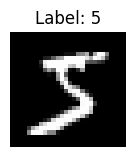

{'Image Type': <class 'torch.Tensor'>, 'Image Shape': torch.Size([1, 28, 28]), 'Label Type': <class 'int'>, 'Label Value': 5}


In [5]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),
    ]
)

train_mnist_dataset = datasets.MNIST(root="dataset", train=True, transform=transform, download=True)
test_mnist_dataset = datasets.MNIST(root="dataset", train=False, transform=transform, download=True)
print(
    f"训练数据集大小：{len(train_mnist_dataset)}，"
    f"测试数据集大小：{len(test_mnist_dataset)}"
)

image, label = train_mnist_dataset[0]
sample = {
    'Image Type': type(image),
    'Image Shape': image.shape,
    'Label Type': type(label),
    'Label Value': label
}
print('A Train Sample:\n')
plt.figure(figsize=(1.5, 1.5))
plt.imshow(image.squeeze(0), cmap='gray')
plt.title(f"Label: {label}")
plt.axis('off')
plt.show()
print(sample)

image_width, image_height = 28, 28
num_classes = 10

接下来手动实现前馈神经网络并训练。

首先手动实现一些工具和基本模型层。这些工具都在前一个实验中实现并测试过，在此就不再分析其原理和具体实现步骤，也不在此重新测试。

In [6]:
# 手动实现torch.nn.functional.softmax
def my_softmax(x: torch.Tensor, dim: int):
    max_x = torch.max(x, dim=dim, keepdim=True).values
    exp_x = torch.exp(x - max_x)
    return exp_x / torch.sum(exp_x, dim=dim, keepdim=True)


# 手动实现torch.nn.Linear
class My_Linear:
    def __init__(self, in_features: int, out_features: int):
        self.weight = torch.randn((out_features, in_features), requires_grad=True, dtype=torch.float32)
        self.bias = torch.zeros(1, requires_grad=True, dtype=torch.float32)
        self.params = [self.weight, self.bias]

    def __call__(self, x: torch.Tensor):
        return self.forward(x)

    def forward(self, x: torch.Tensor):
        x = torch.matmul(x, self.weight.T) + self.bias
        return x

    def to(self, device: str):
        for param in self.params:
            param.data = param.data.to(device=device)
        return self

    def parameters(self):
        return self.params

        
# 手动实现torch.nn.Flatten
class My_Flatten:
    def __call__(self, x: torch.Tensor):
        x = x.view(x.shape[0], -1)
        return x

        
# 手动实现torch.nn.ReLU
class My_ReLU():
    def __call__(self, x: torch.Tensor):
        return torch.where(x > 0, x, torch.zeros_like(x))


# 手动实现torch.nn.LeakyReLU
class My_LeakyReLU():
    def __init__(self, negative_slope=0.01):
        self.negative_slope = negative_slope
    
    def __call__(self, x: torch.Tensor):
        return torch.where(x > 0, x, x * self.negative_slope)


# 手动实现torch.nn.Sigmoid
class My_Sigmoid():
    def __call__(self, x: torch.Tensor):
        z = torch.exp(-x.abs())
        return torch.where(x >= 0, 1 / (1 + z), z / (1 + z))


# 手动实现torch.nn.Softmax
class My_Softmax:
    def __init__(self, dim: int):
        self.dim = dim
    def __call__(self, x: torch.Tensor):
        max_x = torch.max(x, dim=self.dim, keepdim=True).values
        exp_x = torch.exp(x - max_x)
        return exp_x / torch.sum(exp_x, dim=self.dim, keepdim=True)


# 手动实现torch.nn.MSELoss
class My_MSELoss:  
    def __call__(self, prediction: torch.Tensor, target: torch.Tensor):
        loss = torch.mean(torch.square(prediction - target))
        return loss


# 手动实现torch.nn.BCELoss
class My_BCELoss:
    def __call__(self, prediction: torch.Tensor, target: torch.Tensor):
        eps = 1e-9
        loss = -torch.mean(target * torch.log(prediction + eps) + (1 - target) * torch.log(1 - prediction + eps))
        return loss


# 手动实现torch.nn.CrossEntropyLoss
class My_CrossEntropyLoss:
    def __call__(
        self, 
        x: torch.Tensor, 
        targets: torch.Tensor, 
        reduction: Literal["mean", "sum"] = "mean"
    ):
        max_x = torch.max(x, dim=1, keepdim=True).values
        exp_x = torch.exp(x - max_x)
        log_probs = x - max_x - torch.log(torch.sum(exp_x, dim=1, keepdim=True))
        
        if len(x.shape) == len(targets.shape) + 1:
            nll_loss = -log_probs.gather(1, targets.unsqueeze(-1)).squeeze()
        else:
            nll_loss = -torch.sum(targets * log_probs, dim=1)
            
        if reduction == "mean": 
            return torch.mean(nll_loss)
        else: 
            return torch.sum(nll_loss)


# 手动实现torch.optim.SGD
class My_Optimizer:
    def __init__(self, params: list[torch.Tensor], lr: float):
        self.params = list(params)
        self.lr = lr

    def step(self):
        for param in self.params:
            if param.grad is not None:
                param.data = param.data - self.lr * param.grad.data

    def zero_grad(self):
        for param in self.params:
            if param.grad is not None:
                param.grad.data.zero_()

接下来实现Regression回归的Trainer，包括训练流程、测试和画图。

训练Regression回归模型，进行如下步骤：
1. 定义模型、数据集、损失函数、优化器和其他超参数
2. 训练
    1. 从训练dataloader中获取批量数据
    2. 传入模型
    3. 使用损失函数计算与ground_truth的损失
    4. 使用优化器进行反向传播
    5. 循环以上步骤
3. 验证及测试
    1. 从验证或测试dataloader中获取批量数据
    2. 传入模型，验证时需要将模型输出与ground_truth进行比较得计算loss
    3. 将预测值与ground_truth进行比较，得出正确率
    4. 对整个训练集统计正确率，从而分析训练效果

In [7]:
class RegressionTrainer():
    def __init__(
        self,
        model,
        train_dataset: Union[Dataset, DataLoader],
        eval_dataset: Union[Dataset, DataLoader],
        optimizer: Literal['torch', 'manual'],
        criterion: Literal['torch', 'manual'],
        learning_rate: float,
        num_epochs: int,
        batch_size: int,
        test_dataset: Union[Dataset, DataLoader] = None,
        plot: bool = True, 
        print_test_result = True,
        return_curves: bool = False,
        log_epoch: int = 1
    ):
        self.model = model
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs
        self.batch_size = batch_size
        self.plot = plot
        self.print_test_result = print_test_result
        self.return_curves = return_curves
        self.log_epoch = log_epoch

        if isinstance(train_dataset, Dataset):
            self.train_dataloader = DataLoader(
                dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=cpu_count()
            )
        else:
            self.train_dataloader = train_dataset
        if isinstance(eval_dataset, Dataset):
            self.eval_dataloader = DataLoader(
                dataset=eval_dataset, batch_size=batch_size, shuffle=True, num_workers=cpu_count()
            )
        else:
            self.eval_dataloader = eval_dataset
        if isinstance(test_dataset, Dataset):
            self.test_dataloader = DataLoader(
                dataset=test_dataset, batch_size=batch_size, shuffle=True, num_workers=cpu_count()
            )
        else:
            self.test_dataloader = test_dataset

        if optimizer == 'torch':
            self.optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
        else:
            self.optimizer = My_Optimizer(model.parameters(), lr=learning_rate)

        if criterion == 'torch':
            self.criterion = nn.MSELoss()
        else:
            self.criterion = My_MSELoss()

    def train(self):
        train_loss_curve = []
        eval_loss_curve = []
        eval_error_curve = []
        step = 0
        total_train_steps = self.num_epochs * len(self.train_dataloader)
        with tqdm(total=total_train_steps) as pbar:
            for epoch in range(self.num_epochs):
                total_train_loss = 0
                for x, targets in self.train_dataloader:
                    x = x.to(device=device, dtype=torch.float32)
                    targets = targets.to(device=device, dtype=torch.float32)

                    self.optimizer.zero_grad()
                    output = self.model(x)
                    loss = self.criterion(output, targets)
                    total_train_loss += loss.item()
                    train_loss_curve.append(loss.item())
            
                    loss.backward()
                    self.optimizer.step()
                    step += 1
                    pbar.update(1)

                avg_eval_loss, avg_eval_error = self.eval()
                eval_loss_curve.append(avg_eval_loss)
                eval_error_curve.append(avg_eval_error)
                if self.log_epoch > 0 and (epoch + 1) % self.log_epoch == 0:
                    log_info = {
                        'Epoch': f'{epoch + 1}/{self.num_epochs}',
                        'Total Train Loss': f'{total_train_loss:.2f}',
                        'Scaled Total Valid Loss': f'{avg_eval_loss * len(self.train_dataloader):.2f}',
                        'Avg Valid Error': f'{avg_eval_error:.2f}'
                    }
                    print(log_info)

        return_info = {}
        if self.test_dataloader:
            test_error = self.test()
            if self.print_test_result:
                print('Avg Test Error:', f'{test_error:.2f}')
            return_info['test_error'] = test_error
        if self.plot:
            self.plot_results(train_loss_curve, eval_loss_curve, eval_error_curve)
        if self.return_curves:
            curves = {
                'train_loss_curve': train_loss_curve,
                'eval_loss_curve': eval_loss_curve,
                'eval_error_curve': eval_error_curve
            }
            return_info['curves'] = curves
        return return_info

    def eval(self):
        total_eval_loss = 0
        total_eval_error = 0
        total_eval_samples = 0
        with torch.inference_mode():
            for x, targets in self.eval_dataloader:
                x = x.to(device=device, dtype=torch.float32)
                targets = targets.to(device=device, dtype=torch.float32)
                output = self.model(x)
                loss = self.criterion(output, targets)
                total_eval_loss += loss.item()
                total_eval_error += torch.square(output - targets).sum().item()
                total_eval_samples += targets.numel()
        avg_eval_loss = total_eval_loss / len(self.eval_dataloader)
        avg_eval_error = total_eval_error / total_eval_samples
        return avg_eval_loss, avg_eval_error

    def test(self):
        total_test_error = 0
        total_test_samples = 0
        with torch.inference_mode():
            for x, targets in self.test_dataloader:
                x = x.to(device=device, dtype=torch.float32)
                targets = targets.to(device=device, dtype=torch.float32)
                output = self.model(x)
                total_test_error += torch.square(output - targets).sum().item()
                total_test_samples += targets.numel()
        avg_test_error = total_test_error / total_test_samples
        return avg_test_error
        
    def plot_results(self, train_loss_curve, eval_loss_curve, eval_error_curve):
        fig, axes = plt.subplots(1, 2, figsize=(10, 4))
        
        axes[0].plot(train_loss_curve, label='Training Loss', color='blue')
        axes[0].plot(
            np.linspace(len(self.train_dataloader), len(train_loss_curve), len(eval_loss_curve), endpoint=True),
            eval_loss_curve, label='Validation Loss', color='orange'
        )
        axes[0].set_xlabel('Step')
        axes[0].set_ylabel('Loss')
        axes[0].set_title('Loss Curve')
        axes[0].legend()
        axes[0].grid(True, linestyle='--', linewidth=0.5, alpha=0.6)
    
        axes[1].plot(eval_error_curve, label='Validation Error', color='red', marker='o')
        axes[1].set_xlabel('Epoch')
        axes[1].set_ylabel('Error')
        axes[1].set_title('Validation Error Curve')
        axes[1].legend()
        axes[1].grid(True, linestyle='--', linewidth=0.5, alpha=0.6)
    
        plt.tight_layout()
        plt.show()

手动构建回归任务的模型。

In [8]:
class Model_1_1:
    def __init__(self, input_features=500, output_features=1):
        self.linear = My_Linear(in_features=input_features, out_features=output_features)
        self.params = self.linear.params

    def __call__(self, x):
        return self.forward(x)

    def forward(self, x):
        x = self.linear(x)
        return x

    def to(self, device: str):
        for param in self.params:
            param.data = param.data.to(device=device)
        return self

    def parameters(self):
        return self.params
    
    def train(self):
        for param in self.params:
            param.requires_grad = True
    
    def eval(self):
        for param in self.params:
            param.requires_grad = False

开始训练。

  0%|          | 0/70 [00:00<?, ?it/s]

{'Epoch': '1/10', 'Total Train Loss': '769.69', 'Scaled Total Valid Loss': '464.15', 'Avg Valid Error': '66.30'}
{'Epoch': '2/10', 'Total Train Loss': '291.14', 'Scaled Total Valid Loss': '197.26', 'Avg Valid Error': '28.15'}
{'Epoch': '3/10', 'Total Train Loss': '120.49', 'Scaled Total Valid Loss': '90.02', 'Avg Valid Error': '12.87'}
{'Epoch': '4/10', 'Total Train Loss': '54.79', 'Scaled Total Valid Loss': '44.94', 'Avg Valid Error': '6.43'}
{'Epoch': '5/10', 'Total Train Loss': '28.08', 'Scaled Total Valid Loss': '25.07', 'Avg Valid Error': '3.58'}
{'Epoch': '6/10', 'Total Train Loss': '16.56', 'Scaled Total Valid Loss': '15.95', 'Avg Valid Error': '2.28'}
{'Epoch': '7/10', 'Total Train Loss': '11.41', 'Scaled Total Valid Loss': '11.62', 'Avg Valid Error': '1.66'}
{'Epoch': '8/10', 'Total Train Loss': '9.01', 'Scaled Total Valid Loss': '9.55', 'Avg Valid Error': '1.37'}
{'Epoch': '9/10', 'Total Train Loss': '7.85', 'Scaled Total Valid Loss': '8.55', 'Avg Valid Error': '1.22'}
{'Epoc

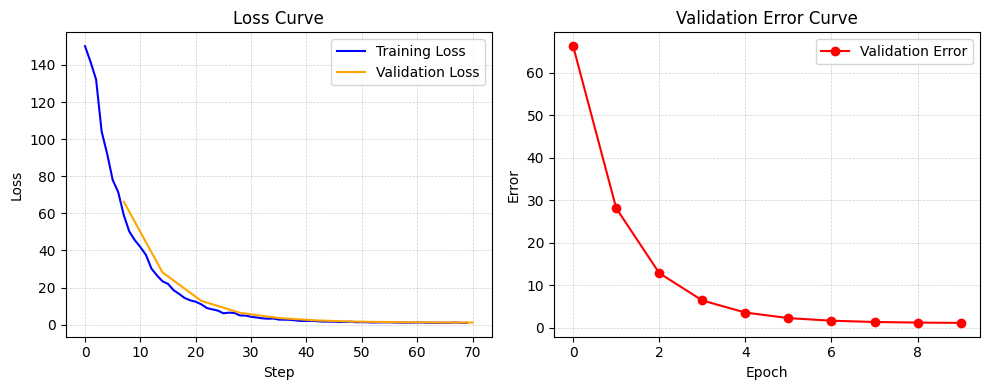

In [9]:
hyper_params = {
    'learning_rate': 1.0e-1,
    'num_epochs': 10,
    'batch_size': 1024,
}

model = Model_1_1().to(device)

trainer = RegressionTrainer(
    model=model, 
    train_dataset=train_regression_dataset, eval_dataset=test_regression_dataset,
    optimizer='manual', criterion='manual', **hyper_params
)
_ = trainer.train()

接下来实现二分类任务的Trainer，包括训练流程、测试和画图。

训练二分类任务模型，进行如下步骤：
1. 定义模型、数据集、损失函数、优化器和其他超参数
2. 训练
    1. 从训练dataloader中获取批量数据
    2. 传入模型
    3. 使用损失函数计算与ground_truth的损失
    4. 使用优化器进行反向传播
    5. 循环以上步骤
3. 验证及测试
    1. 从验证或测试dataloader中获取批量数据
    2. 传入模型，验证时需要将模型输出与ground_truth进行比较得计算loss
    3. 将预测值与ground_truth进行比较，得出正确率
    4. 对整个训练集统计正确率，从而分析训练效果

In [10]:
class BinaryCLSTrainer():
    def __init__(
        self,
        model,
        train_dataset: Union[Dataset, DataLoader],
        eval_dataset: Union[Dataset, DataLoader],
        optimizer: Literal['torch', 'manual'],
        criterion: Literal['torch', 'manual'],
        learning_rate: float,
        num_epochs: int,
        batch_size: int,
        test_dataset: Union[Dataset, DataLoader] = None,
        plot: bool = True, 
        print_test_result: bool = True,
        return_curves: bool = False,
        log_epoch: int = 1
    ):
        self.model = model
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs
        self.batch_size = batch_size
        self.plot = plot
        self.print_test_result = print_test_result
        self.return_curves = return_curves
        self.log_epoch = log_epoch

        if isinstance(train_dataset, Dataset):
            self.train_dataloader = DataLoader(
                dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=cpu_count()
            )
        else:
            self.train_dataloader = train_dataset
        if isinstance(eval_dataset, Dataset):
            self.eval_dataloader = DataLoader(
                dataset=eval_dataset, batch_size=batch_size, shuffle=True, num_workers=cpu_count()
            )
        else:
            self.eval_dataloader = eval_dataset
        if isinstance(test_dataset, Dataset):
            self.test_dataloader = DataLoader(
                dataset=test_dataset, batch_size=batch_size, shuffle=True, num_workers=cpu_count()
            )
        else:
            self.test_dataloader = test_dataset

        if optimizer == 'torch':
            self.optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
        else:
            self.optimizer = My_Optimizer(model.parameters(), lr=learning_rate)

        if criterion == 'torch':
            self.criterion = nn.BCELoss()
        else:
            self.criterion = My_BCELoss()

    def train(self):
        train_loss_curve = []
        eval_loss_curve = []
        eval_acc_curve = []
        step = 0
        total_train_steps = self.num_epochs * len(self.train_dataloader)
        with tqdm(total=total_train_steps) as pbar:
            for epoch in range(self.num_epochs):
                total_train_loss = 0
                for x, targets in self.train_dataloader:
                    x = x.to(device=device, dtype=torch.float32)
                    targets = targets.to(device=device, dtype=torch.float32)

                    self.optimizer.zero_grad()
                    output = self.model(x)
                    loss = self.criterion(output, targets)
                    total_train_loss += loss.item()
                    train_loss_curve.append(loss.item())
            
                    loss.backward()
                    self.optimizer.step()

                    step += 1
                    pbar.update(1)

                avg_eval_loss, avg_eval_acc = self.eval()
                eval_loss_curve.append(avg_eval_loss)
                eval_acc_curve.append(avg_eval_acc)
                if self.log_epoch > 0 and (epoch + 1) % self.log_epoch == 0:
                    log_info = {
                        'Epoch': f'{epoch + 1}/{self.num_epochs}',
                        'Total Train Loss': f'{total_train_loss:.2f}',
                        'Scaled Total Valid Loss': f'{avg_eval_loss * len(self.train_dataloader):.2f}',
                        'Avg Valid Acc': f'{avg_eval_acc:.2%}'
                    }
                    print(log_info)

        return_info = {}
        if self.test_dataloader:
            test_acc = self.test()
            if self.print_test_result:
                print('Avg Test Acc:', f'{test_acc:.2%}')
            return_info['test_acc'] = test_acc
        if self.plot:
            self.plot_results(train_loss_curve, eval_loss_curve, eval_acc_curve)
        if self.return_curves:
            curves = {
                'train_loss_curve': train_loss_curve,
                'eval_loss_curve': eval_loss_curve,
                'eval_acc_curve': eval_acc_curve
            }
            return_info['curves'] = curves
        return return_info

    def eval(self):
        total_eval_loss = 0
        total_eval_acc = 0
        total_eval_samples = 0
        with torch.inference_mode():
            for x, targets in self.eval_dataloader:
                x = x.to(device=device, dtype=torch.float32)
                targets = targets.to(device=device, dtype=torch.float32)
                output = self.model(x)
                loss = self.criterion(output, targets)
                total_eval_loss += loss.item()
                preds = (output >= 0.5).float()
                total_eval_acc += (preds == targets.to(dtype=torch.long)).float().sum().item()
                total_eval_samples += targets.numel()
        avg_eval_loss = total_eval_loss / len(self.eval_dataloader)
        avg_eval_acc = total_eval_acc / total_eval_samples
        return avg_eval_loss, avg_eval_acc

    def test(self):
        total_test_acc = 0
        total_test_samples = 0
        with torch.inference_mode():
            for x, targets in self.test_dataloader:
                x = x.to(device=device, dtype=torch.float32)
                targets = targets.to(device=device, dtype=torch.long)
                output = self.model(x)
                preds = (output >= 0.5).float()
                total_test_acc += (preds == targets).float().sum().item()
                total_test_samples += targets.numel()
        avg_test_acc = total_test_acc / total_test_samples
        return avg_test_acc
        
    def plot_results(self, train_loss_curve, eval_loss_curve, eval_acc_curve):
        fig, axes = plt.subplots(1, 2, figsize=(10, 4))
        
        axes[0].plot(train_loss_curve, label='Training Loss', color='blue')
        axes[0].plot(
            np.linspace(len(self.train_dataloader), len(train_loss_curve), len(eval_loss_curve), endpoint=True),
            eval_loss_curve, label='Validation Loss', color='orange'
        )
        axes[0].set_xlabel('Step')
        axes[0].set_ylabel('Loss')
        axes[0].set_title('Loss Curve')
        axes[0].legend()
        axes[0].grid(True, linestyle='--', linewidth=0.5, alpha=0.6)
    
        axes[1].plot(eval_acc_curve, label='Validation Accuracy', color='green', marker='o')
        axes[1].set_xlabel('Epoch')
        axes[1].set_ylabel('Accuracy')
        axes[1].set_title('Validation Accuracy Curve')
        axes[1].legend()
        axes[1].grid(True, linestyle='--', linewidth=0.5, alpha=0.6)
    
        plt.tight_layout()
        plt.show()

手动构建二分类任务的模型。

In [11]:
class Model_1_2:
    def __init__(self, input_features=200):
        self.fc = My_Linear(in_features=input_features, out_features=1)
        self.sigmoid = My_Sigmoid()
        self.params = self.fc.parameters()

    def __call__(self, x):
        return self.forward(x)

    def forward(self, x):
        x = self.fc(x)
        x = self.sigmoid(x)
        return x

    def to(self, device: str):
        for param in self.params:
            param.data = param.data.to(device=device)
        return self

    def parameters(self):
        return self.params
    
    def train(self):
        for param in self.params:
            param.requires_grad = True
    
    def eval(self):
        for param in self.params:
            param.requires_grad = False

训练并测试上述二分类模型。

  0%|          | 0/140 [00:00<?, ?it/s]

{'Epoch': '1/10', 'Total Train Loss': '2.40', 'Scaled Total Valid Loss': '0.76', 'Avg Valid Acc': '97.95%'}
{'Epoch': '2/10', 'Total Train Loss': '0.60', 'Scaled Total Valid Loss': '0.34', 'Avg Valid Acc': '99.38%'}
{'Epoch': '3/10', 'Total Train Loss': '0.33', 'Scaled Total Valid Loss': '0.21', 'Avg Valid Acc': '99.65%'}
{'Epoch': '4/10', 'Total Train Loss': '0.22', 'Scaled Total Valid Loss': '0.15', 'Avg Valid Acc': '99.83%'}
{'Epoch': '5/10', 'Total Train Loss': '0.17', 'Scaled Total Valid Loss': '0.11', 'Avg Valid Acc': '99.92%'}
{'Epoch': '6/10', 'Total Train Loss': '0.13', 'Scaled Total Valid Loss': '0.09', 'Avg Valid Acc': '99.92%'}
{'Epoch': '7/10', 'Total Train Loss': '0.11', 'Scaled Total Valid Loss': '0.07', 'Avg Valid Acc': '99.95%'}
{'Epoch': '8/10', 'Total Train Loss': '0.09', 'Scaled Total Valid Loss': '0.06', 'Avg Valid Acc': '99.97%'}
{'Epoch': '9/10', 'Total Train Loss': '0.08', 'Scaled Total Valid Loss': '0.05', 'Avg Valid Acc': '99.97%'}
{'Epoch': '10/10', 'Total Tr

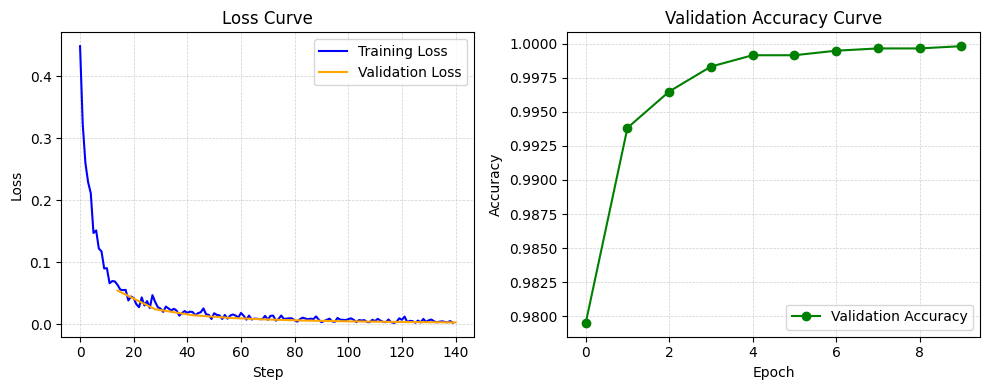

In [12]:
hyper_params = {
    'learning_rate': 5.0e-2,
    'num_epochs': 10,
    'batch_size': 1024,
}

model = Model_1_2().to(device)

trainer = BinaryCLSTrainer(
    model=model, 
    train_dataset=train_binarycls_dataset, eval_dataset=test_binarycls_dataset,
    optimizer='manual', criterion='manual', **hyper_params
)
_ = trainer.train()

接下来实现多分类任务的Trainer，包括训练流程、测试和画图。

训练多分类任务模型，与二分类任务大部分一致，仅修改损失函数，以及对数据类型做适配。

In [13]:
class MultiCLSTrainer():
    def __init__(
        self,
        model,
        train_dataset: Union[Dataset, DataLoader],
        eval_dataset: Union[Dataset, DataLoader],
        optimizer,
        criterion: Literal['torch', 'manual'],
        learning_rate: float,
        num_epochs: int,
        batch_size: int,
        weight_decay: float = 0.0,
        test_dataset: Union[Dataset, DataLoader] = None,
        plot: bool = True, 
        print_test_result: bool = True,
        return_curves: bool = False,
        log_epoch: int = 1
    ):
        self.model = model
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs
        self.batch_size = batch_size
        self.plot = plot
        self.print_test_result = print_test_result
        self.return_curves = return_curves
        self.log_epoch = log_epoch

        if isinstance(train_dataset, Dataset):
            self.train_dataloader = DataLoader(
                dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=cpu_count()
            )
        else:
            self.train_dataloader = train_dataset
        if isinstance(eval_dataset, Dataset):
            self.eval_dataloader = DataLoader(
                dataset=eval_dataset, batch_size=batch_size, shuffle=True, num_workers=cpu_count()
            )
        else:
            self.eval_dataloader = eval_dataset
        if isinstance(test_dataset, Dataset):
            self.test_dataloader = DataLoader(
                dataset=test_dataset, batch_size=batch_size, shuffle=True, num_workers=cpu_count()
            )
        else:
            self.test_dataloader = test_dataset

        if isinstance(optimizer, str):
            if optimizer == 'torch':
                self.optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
            else:
                self.optimizer = My_Optimizer(model.parameters(), lr=learning_rate)
        else:
            self.optimizer = optimizer(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

        if criterion == 'torch':
            self.criterion = nn.CrossEntropyLoss()
            self.softmax = nn.Softmax(dim=1)
        else:
            self.criterion = My_CrossEntropyLoss()
            self.softmax = My_Softmax(dim=1)

    def train(self):
        train_loss_curve = []
        eval_loss_curve = []
        eval_acc_curve = []
        step = 0
        total_train_steps = self.num_epochs * len(self.train_dataloader)
        with tqdm(total=total_train_steps) as pbar:
            for epoch in range(self.num_epochs):
                total_train_loss = 0
                for x, targets in self.train_dataloader:
                    x = x.to(device=device, dtype=torch.float32)
                    targets = targets.to(device=device, dtype=torch.long)

                    self.optimizer.zero_grad()
                    output = self.model(x)
                    loss = self.criterion(output, targets)
                    total_train_loss += loss.item()
                    train_loss_curve.append(loss.item())
            
                    loss.backward()
                    self.optimizer.step()
                    step += 1
                    pbar.update(1)

                avg_eval_loss, avg_eval_acc = self.eval()
                eval_loss_curve.append(avg_eval_loss)
                eval_acc_curve.append(avg_eval_acc)
                if self.log_epoch > 0 and (epoch + 1) % self.log_epoch == 0:
                    log_info = {
                        'Epoch': f'{epoch + 1}/{self.num_epochs}',
                        'Total Train Loss': f'{total_train_loss:.2f}',
                        'Scaled Total Valid Loss': f'{avg_eval_loss * len(self.train_dataloader):.2f}',
                        'Avg Valid Acc': f'{avg_eval_acc:.2%}'
                    }
                    print(log_info)

        return_info = {}
        if self.test_dataloader:
            test_acc = self.test()
            if self.print_test_result:
                print('Avg Test Acc:', f'{test_acc:.2%}')
            return_info['test_acc'] = test_acc
        if self.plot:
            self.plot_results(train_loss_curve, eval_loss_curve, eval_acc_curve)
        if self.return_curves:
            curves = {
                'train_loss_curve': train_loss_curve,
                'eval_loss_curve': eval_loss_curve,
                'eval_acc_curve': eval_acc_curve
            }
            return_info['curves'] = curves
        return return_info

    def eval(self):
        total_eval_loss = 0
        total_eval_acc = 0
        total_eval_samples = 0
        with torch.inference_mode():
            for x, targets in self.eval_dataloader:
                x = x.to(device=device, dtype=torch.float32)
                targets = targets.to(device=device, dtype=torch.long)
                output = self.model(x)
                loss = self.criterion(output, targets)
                total_eval_loss += loss.item()
                preds = self.softmax(output).argmax(dim=1)
                total_eval_acc += (preds == targets).float().sum().item()
                total_eval_samples += targets.numel()
        avg_eval_loss = total_eval_loss / len(self.eval_dataloader)
        avg_eval_acc = total_eval_acc / total_eval_samples
        return avg_eval_loss, avg_eval_acc

    def test(self):
        total_test_acc = 0
        total_test_samples = 0
        with torch.inference_mode():
            for x, targets in self.test_dataloader:
                x = x.to(device=device, dtype=torch.float32)
                targets = targets.to(device=device, dtype=torch.long)
                output = self.model(x)
                preds = self.softmax(output).argmax(dim=1)
                total_test_acc += (preds == targets).float().sum().item()
                total_test_samples += targets.numel()
        avg_test_acc = total_test_acc / total_test_samples
        return avg_test_acc
        
    def plot_results(self, train_loss_curve, eval_loss_curve, eval_acc_curve):
        fig, axes = plt.subplots(1, 2, figsize=(10, 4))
        
        axes[0].plot(train_loss_curve, label='Training Loss', color='blue')
        axes[0].plot(
            np.linspace(len(self.train_dataloader), len(train_loss_curve), len(eval_loss_curve), endpoint=True),
            eval_loss_curve, label='Validation Loss', color='orange'
        )
        axes[0].set_xlabel('Step')
        axes[0].set_ylabel('Loss')
        axes[0].set_title('Loss Curve')
        axes[0].legend()
        axes[0].grid(True, linestyle='--', linewidth=0.5, alpha=0.6)
    
        axes[1].plot(eval_acc_curve, label='Validation Accuracy', color='green', marker='o')
        axes[1].set_xlabel('Epoch')
        axes[1].set_ylabel('Accuracy')
        axes[1].set_title('Validation Accuracy Curve')
        axes[1].legend()
        axes[1].grid(True, linestyle='--', linewidth=0.5, alpha=0.6)
    
        plt.tight_layout()
        plt.show()

手动构建MNIST多分类任务的模型。

In [14]:
class Model_1_3:
    def __init__(self, input_features=784, num_classes=10):
        self.flatten = My_Flatten()
        self.linear = My_Linear(in_features=input_features, out_features=num_classes)
        self.params = self.linear.params

    def __call__(self, x: torch.Tensor):
        return self.forward(x)

    def forward(self, x: torch.Tensor):
        x = self.flatten(x)
        x = self.linear(x)
        return x

    def to(self, device: str):
        for param in self.params:
            param.data = param.data.to(device=device)
        return self

    def parameters(self):
        return self.params
    
    def train(self):
        for param in self.params:
            param.requires_grad = True
    
    def eval(self):
        for param in self.params:
            param.requires_grad = False

训练并测试上述MNIST多分类模型。

  0%|          | 0/590 [00:00<?, ?it/s]

{'Epoch': '1/10', 'Total Train Loss': '838.57', 'Scaled Total Valid Loss': '503.22', 'Avg Valid Acc': '35.28%'}
{'Epoch': '2/10', 'Total Train Loss': '382.18', 'Scaled Total Valid Loss': '300.46', 'Avg Valid Acc': '52.85%'}
{'Epoch': '3/10', 'Total Train Loss': '260.97', 'Scaled Total Valid Loss': '224.79', 'Avg Valid Acc': '61.54%'}
{'Epoch': '4/10', 'Total Train Loss': '207.34', 'Scaled Total Valid Loss': '185.67', 'Avg Valid Acc': '66.55%'}
{'Epoch': '5/10', 'Total Train Loss': '177.52', 'Scaled Total Valid Loss': '161.63', 'Avg Valid Acc': '69.71%'}
{'Epoch': '6/10', 'Total Train Loss': '158.18', 'Scaled Total Valid Loss': '145.88', 'Avg Valid Acc': '72.55%'}
{'Epoch': '7/10', 'Total Train Loss': '144.46', 'Scaled Total Valid Loss': '134.26', 'Avg Valid Acc': '74.28%'}
{'Epoch': '8/10', 'Total Train Loss': '134.35', 'Scaled Total Valid Loss': '125.45', 'Avg Valid Acc': '75.68%'}
{'Epoch': '9/10', 'Total Train Loss': '126.49', 'Scaled Total Valid Loss': '118.48', 'Avg Valid Acc': '7

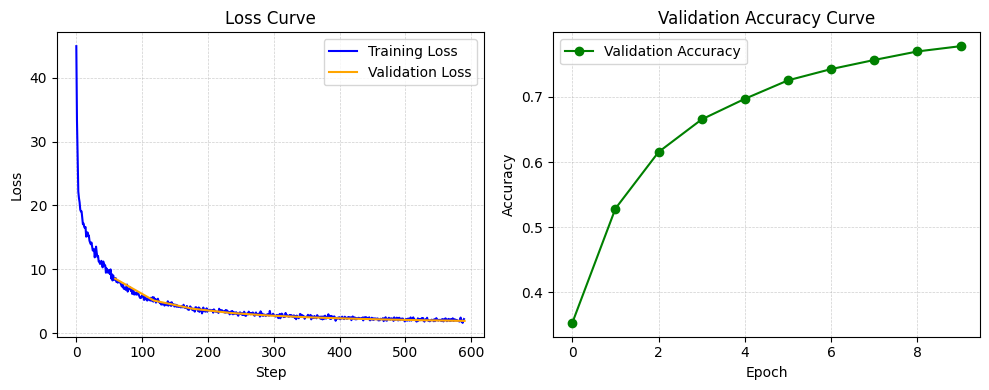

In [15]:
hyper_params = {
    'learning_rate': 6.0e-2,
    'num_epochs': 10,
    'batch_size': 1024,
}

model = Model_1_3(
    input_features=image_width * image_height, 
    num_classes=num_classes
).to(device)

trainer = MultiCLSTrainer(
    model=model, 
    train_dataset=train_mnist_dataset, eval_dataset=test_mnist_dataset, 
    optimizer='manual', criterion='manual', **hyper_params
)
_ = trainer.train()

# 任务二
**利用torch.nn实现前馈神经网络解决上述回归、二分类、多分类任务。**
- 从训练时间、预测精度、Loss变化等角度分析实验结果（最好使用图表展示）

In [16]:
torch.cuda.empty_cache()

使用`torch.nn`构建回归任务的模型。

In [17]:
class Model_2_1(nn.Module):
    def __init__(self, input_features=500):
        super().__init__()
        self.linear = nn.Linear(in_features=input_features, out_features=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.linear(x)
        x = self.sigmoid(x)
        return x

训练并测试上述回归模型。

  0%|          | 0/70 [00:00<?, ?it/s]

{'Epoch': '1/10', 'Total Train Loss': '8.49', 'Scaled Total Valid Loss': '8.37', 'Avg Valid Error': '1.20'}
{'Epoch': '2/10', 'Total Train Loss': '8.27', 'Scaled Total Valid Loss': '8.17', 'Avg Valid Error': '1.17'}
{'Epoch': '3/10', 'Total Train Loss': '8.05', 'Scaled Total Valid Loss': '8.02', 'Avg Valid Error': '1.15'}
{'Epoch': '4/10', 'Total Train Loss': '7.89', 'Scaled Total Valid Loss': '7.89', 'Avg Valid Error': '1.13'}
{'Epoch': '5/10', 'Total Train Loss': '7.76', 'Scaled Total Valid Loss': '7.78', 'Avg Valid Error': '1.11'}
{'Epoch': '6/10', 'Total Train Loss': '7.64', 'Scaled Total Valid Loss': '7.70', 'Avg Valid Error': '1.10'}
{'Epoch': '7/10', 'Total Train Loss': '7.54', 'Scaled Total Valid Loss': '7.63', 'Avg Valid Error': '1.09'}
{'Epoch': '8/10', 'Total Train Loss': '7.45', 'Scaled Total Valid Loss': '7.57', 'Avg Valid Error': '1.08'}
{'Epoch': '9/10', 'Total Train Loss': '7.38', 'Scaled Total Valid Loss': '7.52', 'Avg Valid Error': '1.07'}
{'Epoch': '10/10', 'Total Tr

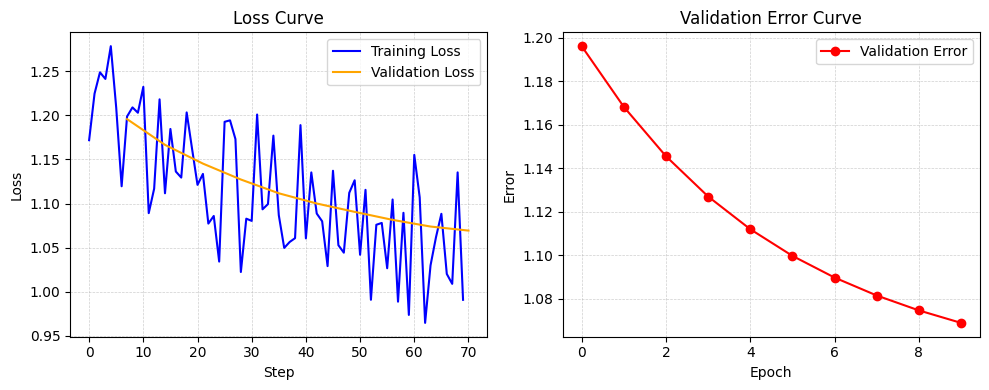

In [18]:
hyper_params = {
    'learning_rate': 1.0e-1,
    'num_epochs': 10,
    'batch_size': 1024,
}

model = Model_2_1().to(device)

trainer = RegressionTrainer(
    model=model, 
    train_dataset=train_regression_dataset, eval_dataset=test_regression_dataset,
    optimizer='torch', criterion='torch', **hyper_params
)
_ = trainer.train()

使用`torch.nn`构建二分类任务的模型。

In [19]:
class Model_2_2(nn.Module):
    def __init__(self, input_features=200):
        super().__init__()
        self.fc = nn.Linear(in_features=input_features, out_features=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc(x)
        x = self.sigmoid(x)
        return x

训练并测试上述二分类模型。

  0%|          | 0/140 [00:00<?, ?it/s]

{'Epoch': '1/10', 'Total Train Loss': '8.87', 'Scaled Total Valid Loss': '8.30', 'Avg Valid Acc': '95.65%'}
{'Epoch': '2/10', 'Total Train Loss': '7.88', 'Scaled Total Valid Loss': '7.41', 'Avg Valid Acc': '99.80%'}
{'Epoch': '3/10', 'Total Train Loss': '7.05', 'Scaled Total Valid Loss': '6.65', 'Avg Valid Acc': '100.00%'}
{'Epoch': '4/10', 'Total Train Loss': '6.34', 'Scaled Total Valid Loss': '6.00', 'Avg Valid Acc': '100.00%'}
{'Epoch': '5/10', 'Total Train Loss': '5.74', 'Scaled Total Valid Loss': '5.45', 'Avg Valid Acc': '100.00%'}
{'Epoch': '6/10', 'Total Train Loss': '5.23', 'Scaled Total Valid Loss': '4.98', 'Avg Valid Acc': '100.00%'}
{'Epoch': '7/10', 'Total Train Loss': '4.79', 'Scaled Total Valid Loss': '4.57', 'Avg Valid Acc': '100.00%'}
{'Epoch': '8/10', 'Total Train Loss': '4.40', 'Scaled Total Valid Loss': '4.21', 'Avg Valid Acc': '100.00%'}
{'Epoch': '9/10', 'Total Train Loss': '4.07', 'Scaled Total Valid Loss': '3.91', 'Avg Valid Acc': '100.00%'}
{'Epoch': '10/10', 'T

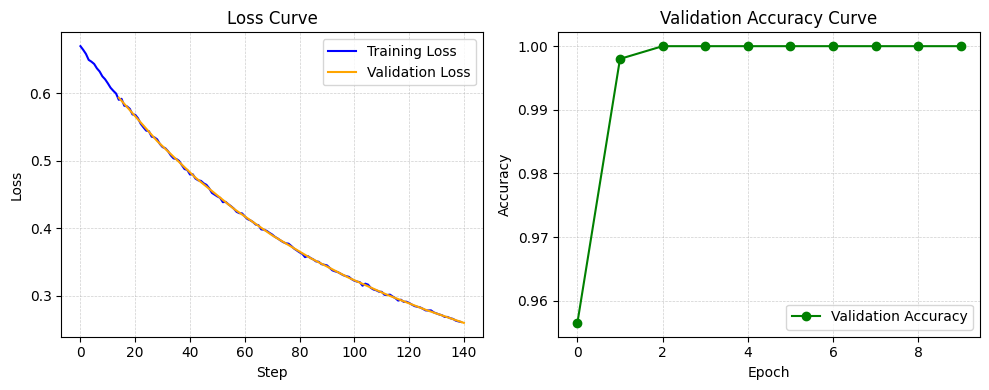

In [20]:
hyper_params = {
    'learning_rate': 5.0e-4,
    'num_epochs': 10,
    'batch_size': 1024,
}

model = Model_2_2().to(device)

trainer = BinaryCLSTrainer(
    model=model, 
    train_dataset=train_binarycls_dataset, eval_dataset=test_binarycls_dataset,
    optimizer='torch', criterion='torch', **hyper_params
)
_ = trainer.train()

使用`torch.nn`构建MNIST多分类任务的模型。

In [21]:
class Model_2_3(nn.Module):
    def __init__(self, input_features=784, num_classes=10):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(in_features=input_features, out_features=num_classes)

    def forward(self, x: torch.Tensor):
        x = self.flatten(x)
        x = self.linear(x)
        return x

训练并测试上述MNIST多分类模型。

  0%|          | 0/590 [00:00<?, ?it/s]

{'Epoch': '1/10', 'Total Train Loss': '62.60', 'Scaled Total Valid Loss': '30.53', 'Avg Valid Acc': '86.13%'}
{'Epoch': '2/10', 'Total Train Loss': '28.31', 'Scaled Total Valid Loss': '25.16', 'Avg Valid Acc': '88.45%'}
{'Epoch': '3/10', 'Total Train Loss': '25.01', 'Scaled Total Valid Loss': '22.58', 'Avg Valid Acc': '89.70%'}
{'Epoch': '4/10', 'Total Train Loss': '23.17', 'Scaled Total Valid Loss': '21.44', 'Avg Valid Acc': '89.96%'}
{'Epoch': '5/10', 'Total Train Loss': '22.04', 'Scaled Total Valid Loss': '20.87', 'Avg Valid Acc': '90.06%'}
{'Epoch': '6/10', 'Total Train Loss': '21.33', 'Scaled Total Valid Loss': '20.09', 'Avg Valid Acc': '90.57%'}
{'Epoch': '7/10', 'Total Train Loss': '20.75', 'Scaled Total Valid Loss': '19.36', 'Avg Valid Acc': '90.74%'}
{'Epoch': '8/10', 'Total Train Loss': '20.22', 'Scaled Total Valid Loss': '19.18', 'Avg Valid Acc': '90.80%'}
{'Epoch': '9/10', 'Total Train Loss': '19.89', 'Scaled Total Valid Loss': '18.82', 'Avg Valid Acc': '91.12%'}
{'Epoch': 

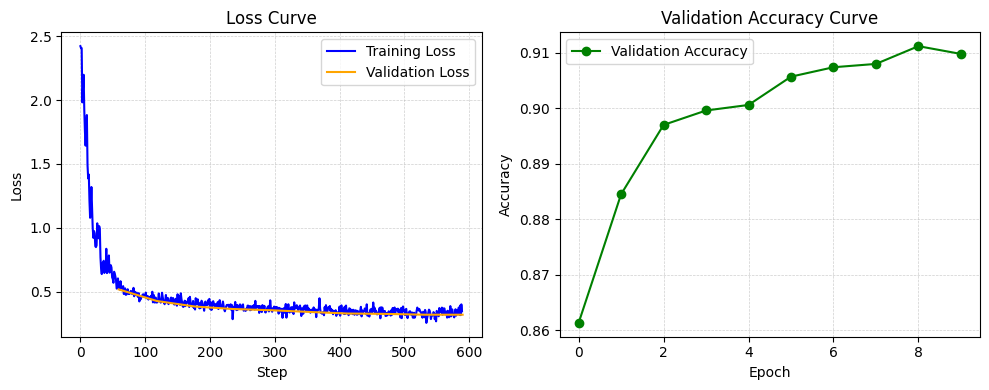

In [22]:
hyper_params = {
    'learning_rate': 6.0e-2,
    'num_epochs': 10,
    'batch_size': 1024,
}

model = Model_2_3(
    input_features=image_width * image_height, 
    num_classes=num_classes
).to(device)

trainer = MultiCLSTrainer(
    model=model, 
    train_dataset=train_mnist_dataset, eval_dataset=test_mnist_dataset, 
    optimizer='torch', criterion='torch', **hyper_params
)
_ = trainer.train()

# 任务三
**在多分类任务中使用至少三种不同的激活函数。**
- 使用不同的激活函数，进行对比实验并分析实验结果


In [23]:
torch.cuda.empty_cache()

接下来定义4个模型，分别使用`nn.ReLU()`、`nn.Sigmoid()`、`nn.Tanh()`和`nn.LeakyReLU()`的实例作为激活函数。

分别训练和测试。并将损失曲线和正确率曲线分别画在一个图内以进行比较4种激活函数的效果。

以ReLU为激活函数的模型开始训练：


  0%|          | 0/590 [00:00<?, ?it/s]

{'Epoch': '10/10', 'Total Train Loss': '15.90', 'Scaled Total Valid Loss': '16.60', 'Avg Valid Acc': '91.41%'}
以Sigmoid为激活函数的模型开始训练：


  0%|          | 0/590 [00:00<?, ?it/s]

{'Epoch': '10/10', 'Total Train Loss': '135.16', 'Scaled Total Valid Loss': '135.09', 'Avg Valid Acc': '11.35%'}
以Tanh为激活函数的模型开始训练：


  0%|          | 0/590 [00:00<?, ?it/s]

{'Epoch': '10/10', 'Total Train Loss': '59.84', 'Scaled Total Valid Loss': '59.09', 'Avg Valid Acc': '91.16%'}
以LeakyReLU为激活函数的模型开始训练：


  0%|          | 0/590 [00:00<?, ?it/s]

{'Epoch': '10/10', 'Total Train Loss': '16.09', 'Scaled Total Valid Loss': '14.88', 'Avg Valid Acc': '92.73%'}


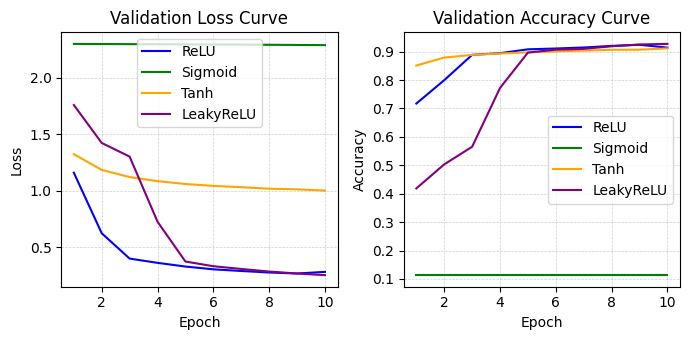

In [24]:
class Model_3(nn.Module):
    def __init__(
        self, 
        activate_fn: Literal['ReLU', 'Sigmoid', 'Tanh', 'LeakyReLU'],
        input_features: int = 784, 
        num_classes: int = 10
    ):
        super().__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(in_features=input_features, out_features=1024)
        self.fc2 = nn.Linear(in_features=1024, out_features=256)
        self.fc3 = nn.Linear(in_features=256, out_features=num_classes)
        if activate_fn == 'ReLU':
            self.activate_fn = nn.ReLU()
        elif activate_fn == 'Sigmoid':
            self.activate_fn = nn.Sigmoid()
        elif activate_fn == 'Tanh':
            self.activate_fn = nn.Tanh()
        elif activate_fn == 'LeakyReLU':
            self.activate_fn = nn.LeakyReLU()

    def forward(self, x: torch.Tensor):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.activate_fn(x)

        x = self.fc2(x)
        x = self.activate_fn(x)

        x = self.fc3(x)
        x = self.activate_fn(x)
        return x
    
models = {
    fn: Model_3(fn, input_features=image_width * image_height, num_classes=num_classes).to(device) 
    for fn in ['ReLU', 'Sigmoid', 'Tanh', 'LeakyReLU']
}
plot_colors = {'ReLU': 'blue', 'Sigmoid': 'green', 'Tanh': 'orange', 'LeakyReLU': 'purple'}

fig, axes = plt.subplots(1, 2, figsize=(7, 3.5))

axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Validation Loss Curve')
axes[0].grid(True, linestyle='--', linewidth=0.5, alpha=0.6)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Validation Accuracy Curve')
axes[1].grid(True, linestyle='--', linewidth=0.5, alpha=0.6)

hyper_params = {
    'learning_rate': 6.0e-2,
    'num_epochs': 10,
    'batch_size': 1024,
}

for fn_name, model in models.items():
    print(f"以{fn_name}为激活函数的模型开始训练：")
    trainer = MultiCLSTrainer(
        model=model, 
        train_dataset=train_mnist_dataset, eval_dataset=test_mnist_dataset, 
        optimizer='torch', criterion='torch', **hyper_params, 
        plot=False, return_curves=True, log_epoch=10
    )
    curves = trainer.train()['curves']

    axes[0].plot(
        range(1, len(curves['eval_loss_curve']) + 1), curves['eval_loss_curve'], 
        label=fn_name, color=plot_colors[fn_name]
    )
    axes[1].plot(
        range(1, len(curves['eval_acc_curve']) + 1), curves['eval_acc_curve'], 
        label=fn_name, color=plot_colors[fn_name]
    )

axes[0].legend()
axes[1].legend()
plt.tight_layout()
plt.show()

在性能表现上，激活函数为`Sigmoid`的模型训练过程中损失下降速度非常慢，可见发生了梯度消失，这验证了`Sigmoid`非常容易出现梯度消失的问题。

激活函数为`ReLU`的模型比较不稳定，有时会出现神经元死亡过多（值为$0$或接近$0$）的情况。

`Tanh`以及`LeakyReLU`的表现相对优秀。

在用时上，各激活函数的模型训练用时相近。

# 任务四
**对多分类任务中的模型评估隐藏层层数和隐藏单元个数对实验结果的影响。**
- 使用不同的隐藏层层数和隐藏单元个数，进行对比实验并分析实验结果


In [25]:
torch.cuda.empty_cache()

接下来定义6个模型，隐藏层层数和隐藏单元个数分别如下：

| 模型编号 | hidden_layer (层数) | hidden_size (隐藏单元个数) |
|:--------:|:-------------------:|:--------------------------:|
| 1        | 2                   | 64                         |
| 2        | 2                   | 1024                       |
| 3        | 4                   | 64                         |
| 4        | 4                   | 1024                       |
| 5        | 8                   | 64                         |
| 6        | 8                   | 1024                       |



分别训练和测试。并将损失曲线和正确率曲线分别画在一个图内以进行比较6个模型的效果。

模型1（隐藏层层数为2，隐藏单元个数为64）开始训练：


  0%|          | 0/590 [00:00<?, ?it/s]

{'Epoch': '10/10', 'Total Train Loss': '16.74', 'Scaled Total Valid Loss': '15.85', 'Avg Valid Acc': '92.05%'}
模型2（隐藏层层数为2，隐藏单元个数为1024）开始训练：


  0%|          | 0/590 [00:00<?, ?it/s]

{'Epoch': '10/10', 'Total Train Loss': '15.05', 'Scaled Total Valid Loss': '14.35', 'Avg Valid Acc': '93.08%'}
模型3（隐藏层层数为4，隐藏单元个数为64）开始训练：


  0%|          | 0/590 [00:00<?, ?it/s]

{'Epoch': '10/10', 'Total Train Loss': '22.21', 'Scaled Total Valid Loss': '20.44', 'Avg Valid Acc': '89.60%'}
模型4（隐藏层层数为4，隐藏单元个数为1024）开始训练：


  0%|          | 0/590 [00:00<?, ?it/s]

{'Epoch': '10/10', 'Total Train Loss': '15.20', 'Scaled Total Valid Loss': '14.95', 'Avg Valid Acc': '92.11%'}
模型5（隐藏层层数为8，隐藏单元个数为64）开始训练：


  0%|          | 0/590 [00:00<?, ?it/s]

{'Epoch': '10/10', 'Total Train Loss': '135.77', 'Scaled Total Valid Loss': '135.76', 'Avg Valid Acc': '11.35%'}
模型6（隐藏层层数为8，隐藏单元个数为1024）开始训练：


  0%|          | 0/590 [00:00<?, ?it/s]

{'Epoch': '10/10', 'Total Train Loss': '135.72', 'Scaled Total Valid Loss': '135.70', 'Avg Valid Acc': '11.35%'}


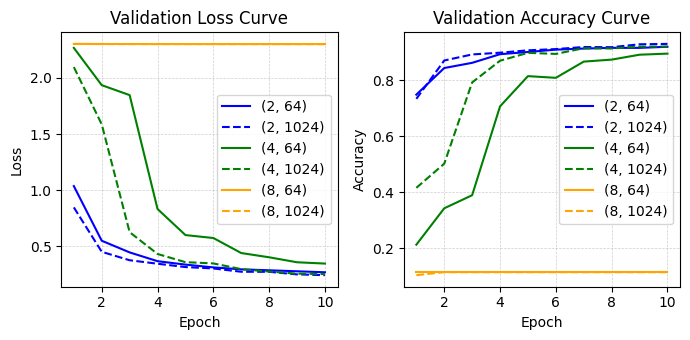

In [26]:
class Model_4(nn.Module):
    def __init__(
        self, 
        hidden_size: int,
        num_hidden_layer: int,
        input_features: int = 784, 
        num_classes: int = 10
    ):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_features, out_features=hidden_size),
            nn.LeakyReLU()
        )
        for i in range(num_hidden_layer - 1):
            self.net.append(nn.Linear(in_features=hidden_size, out_features=hidden_size))
            self.net.append(nn.LeakyReLU())
        self.net.append(nn.Linear(in_features=hidden_size, out_features=num_classes))
        
    def forward(self, x: torch.Tensor):
        return self.net(x)
        
model_arch_params = [
    {'num_hidden_layer': 2, 'hidden_size': 64},
    {'num_hidden_layer': 2, 'hidden_size': 1024},
    {'num_hidden_layer': 4, 'hidden_size': 64},
    {'num_hidden_layer': 4, 'hidden_size': 1024},
    {'num_hidden_layer': 8, 'hidden_size': 64},
    {'num_hidden_layer': 8, 'hidden_size': 1024},
]
plot_colors = ['blue', 'blue', 'green', 'green', 'orange', 'orange']
plot_linestyles = ['solid', 'dashed', 'solid', 'dashed', 'solid', 'dashed']

fig, axes = plt.subplots(1, 2, figsize=(7, 3.5))

axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Validation Loss Curve')
axes[0].grid(True, linestyle='--', linewidth=0.5, alpha=0.6)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Validation Accuracy Curve')
axes[1].grid(True, linestyle='--', linewidth=0.5, alpha=0.6)

hyper_params = {
    'learning_rate': 6.0e-2,
    'num_epochs': 10,
    'batch_size': 1024,
}

for index, arch_param in enumerate(model_arch_params):
    num_hidden_layer, hidden_size = arch_param['num_hidden_layer'], arch_param['hidden_size']
    model = Model_4(**arch_param, input_features=image_width * image_height, num_classes=num_classes).to(device)
    
    print(f"模型{index + 1}（隐藏层层数为{num_hidden_layer}，隐藏单元个数为{hidden_size}）开始训练：")
    trainer = MultiCLSTrainer(
        model=model, 
        train_dataset=train_mnist_dataset, eval_dataset=test_mnist_dataset, 
        optimizer='torch', criterion='torch', **hyper_params, 
        plot=False, return_curves=True, log_epoch=10
    )
    curves = trainer.train()['curves']

    axes[0].plot(
        range(1, len(curves['eval_loss_curve']) + 1), curves['eval_loss_curve'], color=plot_colors[index],
        label=f"({num_hidden_layer}, {hidden_size})", linestyle=plot_linestyles[index]
    )
    axes[1].plot(
        range(1, len(curves['eval_acc_curve']) + 1), curves['eval_acc_curve'], color=plot_colors[index], 
        label=f"({num_hidden_layer}, {hidden_size})", linestyle=plot_linestyles[index]
    )

axes[0].legend()
axes[1].legend()
plt.tight_layout()
plt.show()

在最终性能表现上，前4个模型相差无几，正确率都能达到$89\%$左右。在训练过程中，深层网络的收敛速度慢。当模型层数增加到4以上时，模型无法正常收敛。

以上两个现象可分析得知：深层网络容易出现梯度消失的问题。需要采用残差网络等结构优化。

在用时上，由于模型较小，数据集也较小，GPU算力较高，用时基本没有差别。

# 任务五

**在多分类任务实验中分别手动实现和用torch.nn实现dropout**

- 探究不同丢弃率对实验结果的影响（可用loss曲线进行展示）


In [27]:
torch.cuda.empty_cache()

手动实现Dropout。

由于需要判断此时传入的张量是否是训练状态，需要继承`nn.Module`来获取`self.training`，否则需要手动传入training参数。这里采取前者。

In [28]:
class My_Dropout(nn.Module):
    def __init__(self, p=0.5):
        super().__init__()
        self.p = p
        self.mask = None

    def forward(self, x: torch.Tensor):
        if self.training:
            mask = (torch.rand(x.shape, device=x.device) > self.p).to(x.dtype)
            return x * mask / (1 - self.p)
        else:
            return x
            

# 测试
my_dropout = My_Dropout(p=0.5)
nn_dropout = nn.Dropout(p=0.5)
x = torch.tensor([[1.0, 2.0, 3.0, 4.0, 5.0],
                  [6.0, 7.0, 8.0, 9.0, 10.0]])
print(f"输入：\n{x}")
output_my_dropout = my_dropout(x)
output_nn_dropout = nn_dropout(x)
print(f"My_Dropout输出：\n{output_my_dropout}")
print(f"nn.Dropout输出：\n{output_nn_dropout}")

输入：
tensor([[ 1.,  2.,  3.,  4.,  5.],
        [ 6.,  7.,  8.,  9., 10.]])
My_Dropout输出：
tensor([[ 2.,  0.,  0.,  0.,  0.],
        [ 0., 14.,  0.,  0.,  0.]])
nn.Dropout输出：
tensor([[ 0.,  4.,  6.,  8.,  0.],
        [12., 14.,  0., 18.,  0.]])


使用手动实现的Dropout进行多分类任务训练。

  0%|          | 0/590 [00:00<?, ?it/s]

{'Epoch': '1/10', 'Total Train Loss': '9559.07', 'Scaled Total Valid Loss': '1025.22', 'Avg Valid Acc': '61.21%'}
{'Epoch': '2/10', 'Total Train Loss': '891.85', 'Scaled Total Valid Loss': '729.12', 'Avg Valid Acc': '65.64%'}
{'Epoch': '3/10', 'Total Train Loss': '691.14', 'Scaled Total Valid Loss': '601.95', 'Avg Valid Acc': '67.76%'}
{'Epoch': '4/10', 'Total Train Loss': '592.68', 'Scaled Total Valid Loss': '530.28', 'Avg Valid Acc': '68.37%'}
{'Epoch': '5/10', 'Total Train Loss': '538.68', 'Scaled Total Valid Loss': '479.18', 'Avg Valid Acc': '69.71%'}
{'Epoch': '6/10', 'Total Train Loss': '494.34', 'Scaled Total Valid Loss': '462.81', 'Avg Valid Acc': '70.04%'}
{'Epoch': '7/10', 'Total Train Loss': '468.10', 'Scaled Total Valid Loss': '449.81', 'Avg Valid Acc': '70.69%'}
{'Epoch': '8/10', 'Total Train Loss': '439.43', 'Scaled Total Valid Loss': '412.36', 'Avg Valid Acc': '71.97%'}
{'Epoch': '9/10', 'Total Train Loss': '422.94', 'Scaled Total Valid Loss': '407.92', 'Avg Valid Acc': 

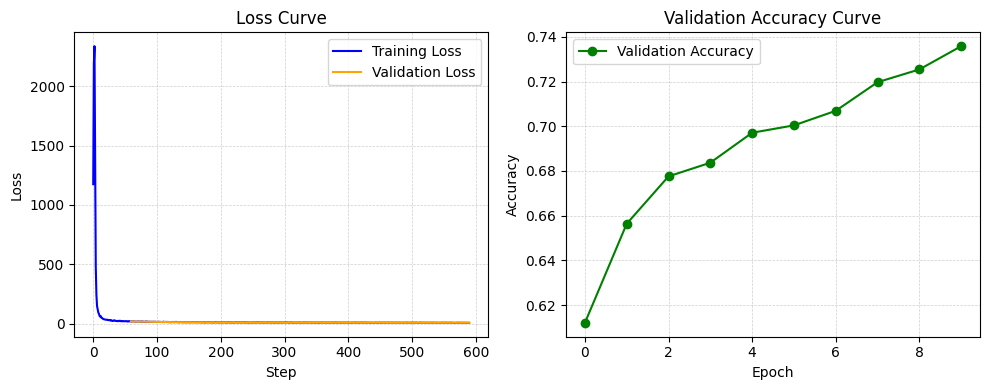

In [29]:
class Model_5_1():
    def __init__(
        self, 
        dropout_p: float = 0.5,
        input_features: int = 784, 
        num_classes: int = 10
    ):
        self.flatten = My_Flatten()
        self.fc1 = My_Linear(in_features=input_features, out_features=1024)
        self.leakyrelu = My_LeakyReLU()
        self.dropout = My_Dropout(p=dropout_p)
        self.fc2 = My_Linear(in_features=1024, out_features=num_classes)
        self.params = self.fc1.params + self.fc2.params

    def __call__(self, x: torch.Tensor):
            return self.forward(x)

    def forward(self, x: torch.Tensor):
        x = self.flatten(x)
        x = self.dropout(self.leakyrelu(self.fc1(x)))
        x = self.fc2(x)
        return x

    def to(self, device: str):
        for param in self.params:
            param.data = param.data.to(device=device)
        return self

    def parameters(self):
        return self.params
    
    def train(self):
        for param in self.params:
            param.requires_grad = True
    
    def eval(self):
        for param in self.params:
            param.requires_grad = False


hyper_params = {
    'learning_rate': 6.0e-2,
    'num_epochs': 10,
    'batch_size': 1024,
}

model = Model_5_1(
    input_features=image_width * image_height, 
    num_classes=num_classes
).to(device)

trainer = MultiCLSTrainer(
    model=model, 
    train_dataset=train_mnist_dataset, eval_dataset=test_mnist_dataset, 
    optimizer='manual', criterion='manual', **hyper_params
)
_ = trainer.train()

探究不同丢弃率对实验结果的影响。

模型1（丢弃率为0.0）开始训练：


  0%|          | 0/590 [00:00<?, ?it/s]

{'Epoch': '10/10', 'Total Train Loss': '12.82', 'Scaled Total Valid Loss': '13.02', 'Avg Valid Acc': '93.18%'}
模型2（丢弃率为0.2）开始训练：


  0%|          | 0/590 [00:00<?, ?it/s]

{'Epoch': '10/10', 'Total Train Loss': '14.17', 'Scaled Total Valid Loss': '13.75', 'Avg Valid Acc': '93.04%'}
模型3（丢弃率为0.5）开始训练：


  0%|          | 0/590 [00:00<?, ?it/s]

{'Epoch': '10/10', 'Total Train Loss': '16.85', 'Scaled Total Valid Loss': '15.49', 'Avg Valid Acc': '92.30%'}
模型4（丢弃率为0.9）开始训练：


  0%|          | 0/590 [00:00<?, ?it/s]

{'Epoch': '10/10', 'Total Train Loss': '102.58', 'Scaled Total Valid Loss': '102.01', 'Avg Valid Acc': '29.78%'}


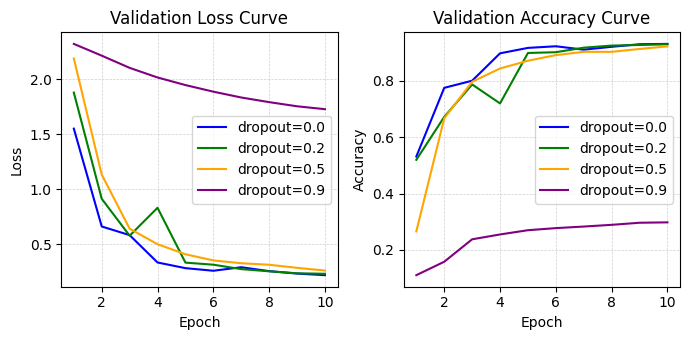

In [30]:
class Model_5_2(nn.Module):
    def __init__(
        self, 
        dropout_p: float = None,
        input_features: int = 784, 
        num_classes: int = 10
    ):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_features, out_features=4096),
            nn.LeakyReLU(),
            nn.Dropout(p=dropout_p),
            nn.Linear(in_features=4096, out_features=4096),
            nn.LeakyReLU(),
            nn.Dropout(p=dropout_p),
            nn.Linear(in_features=4096, out_features=4096),
            nn.LeakyReLU(),
            nn.Dropout(p=dropout_p),
            nn.Linear(in_features=4096, out_features=4096),
            nn.LeakyReLU(),
            nn.Dropout(p=dropout_p),
            nn.Linear(in_features=4096, out_features=num_classes)
        )

    def forward(self, x: torch.Tensor):
        return self.net(x)
        
dropout_ratios = [0.0, 0.2, 0.5, 0.9]
plot_colors = ['blue', 'green', 'orange', 'purple']

fig, axes = plt.subplots(1, 2, figsize=(7, 3.5))

axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Validation Loss Curve')
axes[0].grid(True, linestyle='--', linewidth=0.5, alpha=0.6)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Validation Accuracy Curve')
axes[1].grid(True, linestyle='--', linewidth=0.5, alpha=0.6)

hyper_params = {
    'learning_rate': 6.0e-2,
    'num_epochs': 10,
    'batch_size': 1024,
}

for index, dropout_ratio in enumerate(dropout_ratios):
    model = Model_5_2(dropout_p=dropout_ratio, input_features=image_width * image_height, num_classes=num_classes).to(device)
    
    print(f"模型{index + 1}（丢弃率为{dropout_ratio}）开始训练：")
    trainer = MultiCLSTrainer(
        model=model, 
        train_dataset=train_mnist_dataset, eval_dataset=test_mnist_dataset, 
        optimizer='torch', criterion='torch', **hyper_params, 
        plot=False, return_curves=True, log_epoch=10
    )
    curves = trainer.train()['curves']

    axes[0].plot(
        range(1, len(curves['eval_loss_curve']) + 1), curves['eval_loss_curve'],
        label=f"dropout={dropout_ratio}", color=plot_colors[index]
    )
    axes[1].plot(
        range(1, len(curves['eval_acc_curve']) + 1), curves['eval_acc_curve'], 
        label=f"dropout={dropout_ratio}", color=plot_colors[index]
    )

axes[0].legend()
axes[1].legend()
plt.tight_layout()
plt.show()

# 任务六

**在多分类任务实验中分别手动实现和用torch.nn实现$L_2$正则化**

- 探究惩罚项的权重对实验结果的影响（可用loss曲线进行展示）


In [31]:
torch.cuda.empty_cache()

$L_2$正则化，又称权重衰减，pytorch的的实现是将$L_2$正则化的系数作为优化器的`weight_decay`参数传入，在`step()`的过程中计算完成。具体原理如下：

$L_2$正则化的公式是

$$
L = L_0 + \frac{\lambda }{2n} \sum_{w}^{}w^2
$$

其中$L$是进行$L_2$正则化后的损失，$L_0$是损失函数计算出来的原损失，$\lambda$是$L_2$正则化系数/惩罚项权重（即optimizer的`weight_decay`参数），$n$是样本大小。

反向传播：

$$
\begin{align}
\frac{\partial L}{\partial w} & = \frac{\partial L_0}{\partial w} + \sum_{w}^{} \frac{\lambda }{n} w \\
\frac{\partial L}{\partial b} & = \frac{\partial L_0}{\partial b}
\end{align}
$$

所以，参数更新为：

$$
\begin{align}
w: & = w - \frac{\eta}{n}\frac{\partial L_0}{\partial w} - \frac{\eta \lambda }{n}\sum_{w}^{}w \\
b: & = b - \frac{\eta}{n}\frac{\partial L_0}{\partial b}
\end{align}
$$

其中$\eta$是学习率。

所以，手动在优化器中实现$L_2$正则化如下：

In [32]:
class My_SGD:
    def __init__(self, params: list[torch.Tensor], lr: float, weight_decay=0.0):
        self.params = params
        self.lr = lr
        self.weight_decay = weight_decay

    def step(self):
        with torch.no_grad():
            for param in self.params:
                if param.grad is not None:
                    if len(param.data.shape) > 1:
                        param.data = param.data - self.lr * (param.grad + self.weight_decay * param.data)
                    else:
                        param.data = param.data - self.lr * param.grad

    def zero_grad(self):
        for param in self.params:
            if param.grad is not None:
                param.grad.data = torch.zeros_like(param.grad.data)


# 测试
params1 = torch.tensor([[1., 2, ]], requires_grad=True)
params2 = torch.tensor([[1., 2, ]], requires_grad=True)

my_sgd = My_SGD(params=[params1], lr=0.5, weight_decay=0.1)
optim_sgd = torch.optim.SGD(params=[params2], lr=0.5, weight_decay=0.1)
my_sgd.zero_grad()
optim_sgd.zero_grad()

loss1 = 2 * params1.sum()
loss2 = 2 * params2.sum()
 # 偏导为2
loss1.backward()
loss2.backward()
print("params1的梯度为：\n", params1.grad.data)
print("params2的梯度为：\n", params2.grad.data)

my_sgd.step()
optim_sgd.step()
# 结果为：w - lr * grad - lr * weight_decay_rate * w
# w[0] = 1 - 0.5 * 2 - 0.5 * 0.1 * 1 = -0.0500
# w[1] = 2 - 0.5 * 2 - 0.5 * 0.1 * 2 = 0.9000
print("经过L_2正则化后的My_SGD反向传播结果：\n", params1.data)
print("经过L_2正则化后的torch.optim.SGD反向传播结果：\n", params2.data)

params1的梯度为：
 tensor([[2., 2.]])
params2的梯度为：
 tensor([[2., 2.]])
经过L_2正则化后的My_SGD反向传播结果：
 tensor([[-0.0500,  0.9000]])
经过L_2正则化后的torch.optim.SGD反向传播结果：
 tensor([[-0.0500,  0.9000]])


使用手动实现的带$L_2$正则项的优化器进行多分类任务训练。

  0%|          | 0/590 [00:00<?, ?it/s]

{'Epoch': '1/10', 'Total Train Loss': '13266.24', 'Scaled Total Valid Loss': '225.38', 'Avg Valid Acc': '67.70%'}
{'Epoch': '2/10', 'Total Train Loss': '149.26', 'Scaled Total Valid Loss': '130.71', 'Avg Valid Acc': '52.37%'}
{'Epoch': '3/10', 'Total Train Loss': '100.84', 'Scaled Total Valid Loss': '76.51', 'Avg Valid Acc': '60.38%'}
{'Epoch': '4/10', 'Total Train Loss': '74.90', 'Scaled Total Valid Loss': '66.35', 'Avg Valid Acc': '65.02%'}
{'Epoch': '5/10', 'Total Train Loss': '62.80', 'Scaled Total Valid Loss': '62.20', 'Avg Valid Acc': '68.23%'}
{'Epoch': '6/10', 'Total Train Loss': '58.05', 'Scaled Total Valid Loss': '53.42', 'Avg Valid Acc': '75.31%'}
{'Epoch': '7/10', 'Total Train Loss': '51.98', 'Scaled Total Valid Loss': '46.64', 'Avg Valid Acc': '79.61%'}
{'Epoch': '8/10', 'Total Train Loss': '46.84', 'Scaled Total Valid Loss': '44.85', 'Avg Valid Acc': '79.73%'}
{'Epoch': '9/10', 'Total Train Loss': '45.81', 'Scaled Total Valid Loss': '42.45', 'Avg Valid Acc': '82.64%'}
{'E

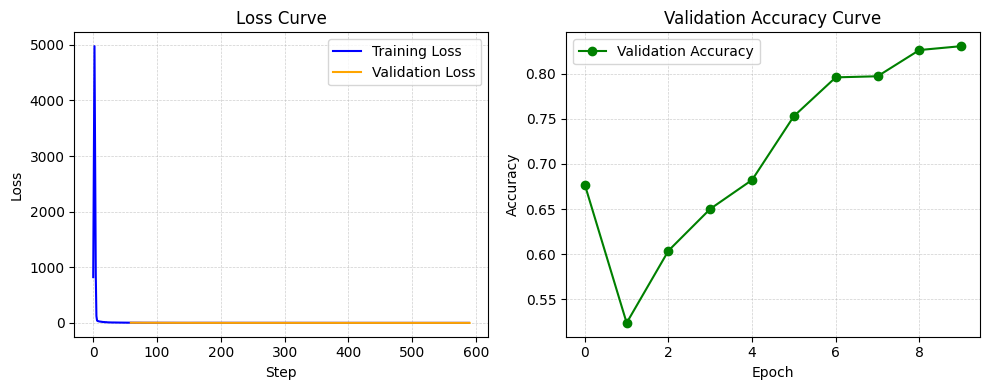

In [33]:
hyper_params = {
    'learning_rate': 6.0e-2,
    'num_epochs': 10,
    'batch_size': 1024,
    'weight_decay': 0.1
}

model = Model_5_1(
    dropout_p=0.0,
    input_features=image_width * image_height, 
    num_classes=num_classes
).to(device)

trainer = MultiCLSTrainer(
    model=model, 
    train_dataset=train_mnist_dataset, eval_dataset=test_mnist_dataset, 
    optimizer=My_SGD, criterion='manual', **hyper_params
)
_ = trainer.train()

探究惩罚项的权重对实验结果的影响。

模型1（训练正则项系数为0.0）开始训练：


  0%|          | 0/590 [00:00<?, ?it/s]

{'Epoch': '10/10', 'Total Train Loss': '110.98', 'Scaled Total Valid Loss': '114.33', 'Avg Valid Acc': '81.89%'}
模型2（训练正则项系数为0.1）开始训练：


  0%|          | 0/590 [00:00<?, ?it/s]

{'Epoch': '10/10', 'Total Train Loss': '29.31', 'Scaled Total Valid Loss': '29.37', 'Avg Valid Acc': '88.45%'}
模型3（训练正则项系数为0.5）开始训练：


  0%|          | 0/590 [00:00<?, ?it/s]

{'Epoch': '10/10', 'Total Train Loss': '88.02', 'Scaled Total Valid Loss': '87.13', 'Avg Valid Acc': '62.48%'}
模型4（训练正则项系数为0.9）开始训练：


  0%|          | 0/590 [00:00<?, ?it/s]

{'Epoch': '10/10', 'Total Train Loss': '126.15', 'Scaled Total Valid Loss': '125.85', 'Avg Valid Acc': '29.15%'}


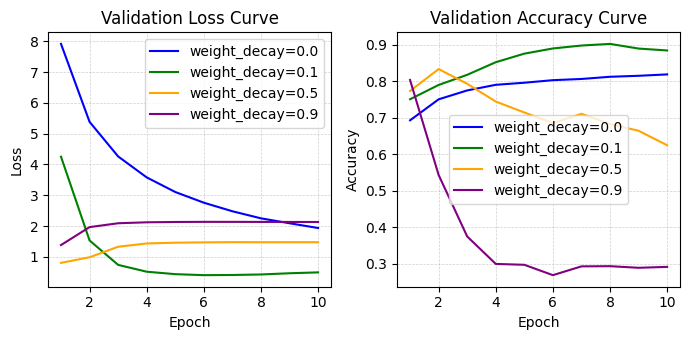

In [34]:
weight_decays = [0.0, 0.1, 0.5, 0.9]
plot_colors = ['blue', 'green', 'orange', 'purple']

fig, axes = plt.subplots(1, 2, figsize=(7, 3.5))

axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Validation Loss Curve')
axes[0].grid(True, linestyle='--', linewidth=0.5, alpha=0.6)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Validation Accuracy Curve')
axes[1].grid(True, linestyle='--', linewidth=0.5, alpha=0.6)

hyper_params_list = [
    {
        'learning_rate': 6.0e-2, 'num_epochs': 10, 'batch_size': 1024,
        'weight_decay': weight_decay
    } 
    for weight_decay in weight_decays
]

for index, hyper_params in enumerate(hyper_params_list):
    model = Model_5_1(dropout_p=0.0, input_features=image_width * image_height, num_classes=num_classes).to(device)
    
    print(f"模型{index + 1}（训练正则项系数为{hyper_params['weight_decay']}）开始训练：")
    trainer = MultiCLSTrainer(
        model=model, 
        train_dataset=train_mnist_dataset, eval_dataset=test_mnist_dataset, 
        optimizer='torch', criterion='torch', **hyper_params, 
        plot=False, return_curves=True, log_epoch=10
    )
    curves = trainer.train()['curves']

    axes[0].plot(
        range(1, len(curves['eval_loss_curve']) + 1), curves['eval_loss_curve'],
        label=f"weight_decay={hyper_params['weight_decay']}", color=plot_colors[index]
    )
    axes[1].plot(
        range(1, len(curves['eval_acc_curve']) + 1), curves['eval_acc_curve'], 
        label=f"weight_decay={hyper_params['weight_decay']}", color=plot_colors[index]
    )

axes[0].legend()
axes[1].legend()
plt.tight_layout()
plt.show()

# 任务七

**对回归、二分类、多分类任务分别选择上述实验中效果最好的模型，采用10折交叉验证评估实验结果**

- 要求除了最终结果外还需以表格的形式展示每折的实验结果


In [35]:
torch.cuda.empty_cache()

制造$k$折数据集，将原先的训练集和测试集混合，然后按照$k-1:1$的比例，按照顺序拆分出$k$对训练集和测试集。

In [36]:
class KFoldDatasetSplitter:
    def __init__(self, dataset, k_folds: int=10, shuffle=True):
        self.dataset = dataset
        self.k_folds = k_folds
        self.shuffle = shuffle

        self.kfold = KFold(n_splits=k_folds, shuffle=shuffle, random_state=seed)
        self.indices = list(range(len(dataset)))
        self.splits = list(self.kfold.split(self.indices))

    def get_fold(self, fold_idx: int):
        assert 0 <= fold_idx and fold_idx < self.k_folds, "fold_idx out of range"

        train_idx, val_idx = self.splits[fold_idx]
        train_subset = Subset(self.dataset, train_idx)
        val_subset = Subset(self.dataset, val_idx)

        return train_subset, val_subset

    def __len__(self):
        return self.k_folds

回归任务。

模型使用第1组数据开始训练：


  0%|          | 0/70 [00:00<?, ?it/s]

模型使用第2组数据开始训练：


  0%|          | 0/70 [00:00<?, ?it/s]

模型使用第3组数据开始训练：


  0%|          | 0/70 [00:00<?, ?it/s]

模型使用第4组数据开始训练：


  0%|          | 0/70 [00:00<?, ?it/s]

模型使用第5组数据开始训练：


  0%|          | 0/70 [00:00<?, ?it/s]

模型使用第6组数据开始训练：


  0%|          | 0/70 [00:00<?, ?it/s]

模型使用第7组数据开始训练：


  0%|          | 0/70 [00:00<?, ?it/s]

模型使用第8组数据开始训练：


  0%|          | 0/70 [00:00<?, ?it/s]

模型使用第9组数据开始训练：


  0%|          | 0/70 [00:00<?, ?it/s]

模型使用第10组数据开始训练：


  0%|          | 0/70 [00:00<?, ?it/s]

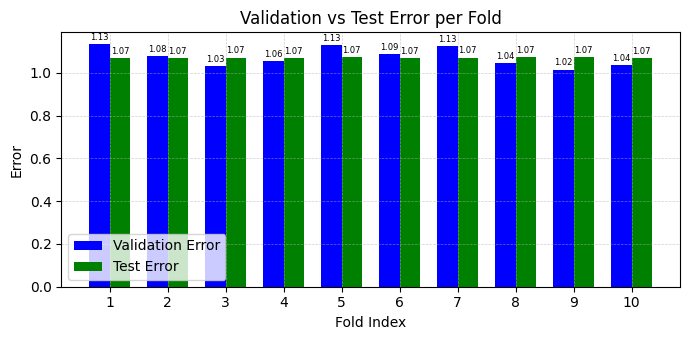

In [37]:
k_fold_splitter = KFoldDatasetSplitter(train_regression_dataset, k_folds=10, shuffle=True)

hyper_params = {
    'learning_rate': 1.0e-1,
    'num_epochs': 10,
    'batch_size': 1024,
}

eval_errors = []
test_errors = []

for index in range(len(k_fold_splitter)):
    model = Model_2_1().to(device)
    train_dataset, eval_dataset = k_fold_splitter.get_fold(fold_idx=index)
    print(f"模型使用第{index + 1}组数据开始训练：")
    trainer = RegressionTrainer(
        model=model, 
        train_dataset=train_dataset, eval_dataset=eval_dataset, test_dataset=test_regression_dataset,
        optimizer='torch', criterion='torch', **hyper_params,
        plot=False, print_test_result=False, return_curves=True, log_epoch=0
    )
    train_result = trainer.train()
    eval_errors.append(train_result['curves']['eval_error_curve'][-1])
    test_errors.append(train_result['test_error'])

fig, ax = plt.subplots(figsize=(7, 3.5))

fold_indices = list(range(1, len(k_fold_splitter) + 1))
bar_width = 0.35
x = np.arange(len(fold_indices))

val_bars = ax.bar(x - bar_width / 2, eval_errors, width=bar_width, label='Validation Error', color='blue')
test_bars = ax.bar(x + bar_width / 2, test_errors, width=bar_width, label='Test Error', color='green')

ax.set_xlabel('Fold Index')
ax.set_ylabel('Error')
ax.set_title('Validation vs Test Error per Fold')
ax.set_xticks(x)
ax.set_xticklabels(fold_indices)
ax.legend()
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.6)

for bar in val_bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height + 0.01, f'{height:.2f}', ha='center', va='bottom', fontsize=6)
for bar in test_bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height + 0.01, f'{height:.2f}', ha='center', va='bottom', fontsize=6)

plt.tight_layout()
plt.show()

二分类任务。

模型使用第1组数据开始训练：


  0%|          | 0/130 [00:00<?, ?it/s]

模型使用第2组数据开始训练：


  0%|          | 0/130 [00:00<?, ?it/s]

模型使用第3组数据开始训练：


  0%|          | 0/130 [00:00<?, ?it/s]

模型使用第4组数据开始训练：


  0%|          | 0/130 [00:00<?, ?it/s]

模型使用第5组数据开始训练：


  0%|          | 0/130 [00:00<?, ?it/s]

模型使用第6组数据开始训练：


  0%|          | 0/130 [00:00<?, ?it/s]

模型使用第7组数据开始训练：


  0%|          | 0/130 [00:00<?, ?it/s]

模型使用第8组数据开始训练：


  0%|          | 0/130 [00:00<?, ?it/s]

模型使用第9组数据开始训练：


  0%|          | 0/130 [00:00<?, ?it/s]

模型使用第10组数据开始训练：


  0%|          | 0/130 [00:00<?, ?it/s]

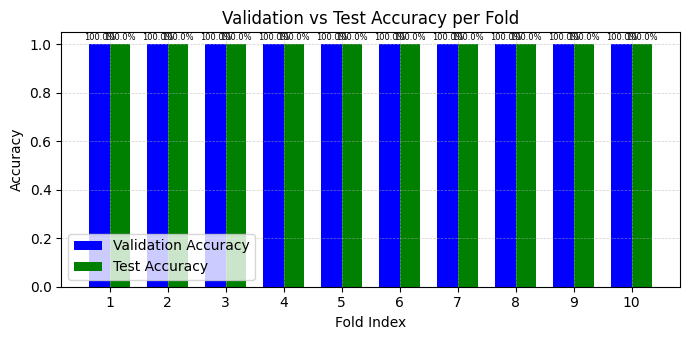

In [38]:
k_fold_splitter = KFoldDatasetSplitter(train_binarycls_dataset, k_folds=10, shuffle=True)

hyper_params = {
    'learning_rate': 5.0e-4,
    'num_epochs': 10,
    'batch_size': 1024,
}

eval_accs = []
test_accs = []

for index in range(len(k_fold_splitter)):
    model = Model_2_2().to(device)
    train_dataset, eval_dataset = k_fold_splitter.get_fold(fold_idx=index)
    print(f"模型使用第{index + 1}组数据开始训练：")
    trainer = BinaryCLSTrainer(
        model=model, 
        train_dataset=train_dataset, eval_dataset=eval_dataset, test_dataset=test_binarycls_dataset,
        optimizer='torch', criterion='torch', **hyper_params,
        plot=False, print_test_result=False, return_curves=True, log_epoch=0
    )
    train_result = trainer.train()
    eval_accs.append(train_result['curves']['eval_acc_curve'][-1])
    test_accs.append(train_result['test_acc'])

fig, ax = plt.subplots(figsize=(7, 3.5))

fold_indices = list(range(1, len(k_fold_splitter) + 1))
bar_width = 0.35
x = np.arange(len(fold_indices))

val_bars = ax.bar(x - bar_width / 2, eval_accs, width=bar_width, label='Validation Accuracy', color='blue')
test_bars = ax.bar(x + bar_width / 2, test_accs, width=bar_width, label='Test Accuracy', color='green')

ax.set_xlabel('Fold Index')
ax.set_ylabel('Accuracy')
ax.set_title('Validation vs Test Accuracy per Fold')
ax.set_xticks(x)
ax.set_xticklabels(fold_indices)
ax.legend()
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.6)

for bar in val_bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height + 0.01, f'{height:.1%}', ha='center', va='bottom', fontsize=6)
for bar in test_bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height + 0.01, f'{height:.1%}', ha='center', va='bottom', fontsize=6)

plt.tight_layout()
plt.show()

多分类任务。

模型使用第1组数据开始训练：


  0%|          | 0/530 [00:00<?, ?it/s]

模型使用第2组数据开始训练：


  0%|          | 0/530 [00:00<?, ?it/s]

模型使用第3组数据开始训练：


  0%|          | 0/530 [00:00<?, ?it/s]

模型使用第4组数据开始训练：


  0%|          | 0/530 [00:00<?, ?it/s]

模型使用第5组数据开始训练：


  0%|          | 0/530 [00:00<?, ?it/s]

模型使用第6组数据开始训练：


  0%|          | 0/530 [00:00<?, ?it/s]

模型使用第7组数据开始训练：


  0%|          | 0/530 [00:00<?, ?it/s]

模型使用第8组数据开始训练：


  0%|          | 0/530 [00:00<?, ?it/s]

模型使用第9组数据开始训练：


  0%|          | 0/530 [00:00<?, ?it/s]

模型使用第10组数据开始训练：


  0%|          | 0/530 [00:00<?, ?it/s]

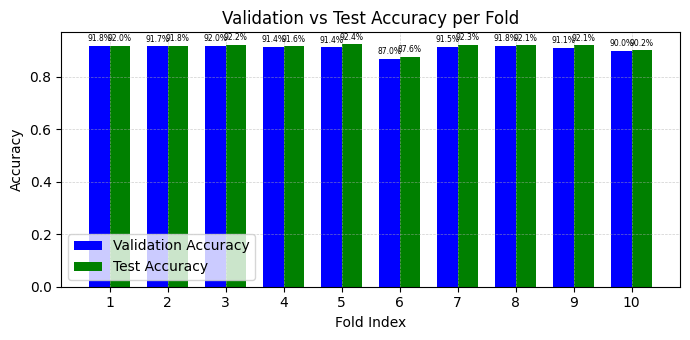

In [39]:
k_fold_splitter = KFoldDatasetSplitter(train_mnist_dataset, k_folds=10, shuffle=True)

hyper_params = {
    'learning_rate': 6.0e-2,
    'num_epochs': 10,
    'batch_size': 1024,
}

eval_accs = []
test_accs = []

for index in range(len(k_fold_splitter)):
    model = Model_4(
        num_hidden_layer=4, hidden_size=1024, 
        input_features=image_width * image_height, num_classes=num_classes
    ).to(device)
    train_dataset, eval_dataset = k_fold_splitter.get_fold(fold_idx=index)
    print(f"模型使用第{index + 1}组数据开始训练：")
    trainer = MultiCLSTrainer(
        model=model, 
        train_dataset=train_dataset, eval_dataset=eval_dataset, test_dataset=test_mnist_dataset,
        optimizer='torch', criterion='torch', **hyper_params,
        plot=False, print_test_result=False, return_curves=True, log_epoch=0
    )
    train_result = trainer.train()
    eval_accs.append(train_result['curves']['eval_acc_curve'][-1])
    test_accs.append(train_result['test_acc'])

fig, ax = plt.subplots(figsize=(7, 3.5))

fold_indices = list(range(1, len(k_fold_splitter) + 1))
bar_width = 0.35
x = np.arange(len(fold_indices))

val_bars = ax.bar(x - bar_width / 2, eval_accs, width=bar_width, label='Validation Accuracy', color='blue')
test_bars = ax.bar(x + bar_width / 2, test_accs, width=bar_width, label='Test Accuracy', color='green')

ax.set_xlabel('Fold Index')
ax.set_ylabel('Accuracy')
ax.set_title('Validation vs Test Accuracy per Fold')
ax.set_xticks(x)
ax.set_xticklabels(fold_indices)
ax.legend()
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.6)

for bar in val_bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height + 0.01, f'{height:.1%}', ha='center', va='bottom', fontsize=5.5)
for bar in test_bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height + 0.01, f'{height:.1%}', ha='center', va='bottom', fontsize=5.5)

plt.tight_layout()
plt.show()